# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [128]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import torch
import numpy as np
import math
import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import keras.backend as K
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score

In [129]:
"""
tf.enable_v2_behavior()



builder = tfds.builder('mnist')
BATCH_SIZE = 32
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes."""

"\ntf.enable_v2_behavior()\n\n\n\nbuilder = tfds.builder('mnist')\nBATCH_SIZE = 32\nNUM_EPOCHS = 12\nNUM_CLASSES = 10  # 10 total classes."

# Google Drive Connect



In [130]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading

In [131]:
# Load train and test splits.
data = pd.read_csv("/content/drive/MyDrive/ECE1512ProjA/annotations.csv")
data.head()

,Image,Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


In [132]:
Train = []
Tlabel = []#1 for SSA,0 for HP
Val = []
Vlabel = []
for i,p in enumerate(data.Partition):
  img = os.path.join("/content/drive/MyDrive/ECE1512ProjA/images/",data.Image[i])
  #img = cv2.imread("/content/drive/MyDrive/ECE1512ProjA/images/" + data.Image[i])
  label = 1 if data.Label[i] == "SSA" else 0
  #print(label,data.Label[i])
  if p == "train":
    Train.append(img)
    Tlabel.append(label)
  else:
    Val.append(img)
    Vlabel.append(label)

In [133]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.labels = labels

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        # print(index)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = cv2.imread(ID)
            y[i] = self.labels[i]


        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [134]:
TRAIN= DataGenerator(Train,Tlabel)
Val= DataGenerator(Val,Vlabel)

# Model creation

In [135]:
base_teacher = tf.keras.applications.resnet_v2.ResNet50V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
imgs = base_teacher.input
midput = base_teacher(imgs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
midput = keras.layers.GlobalAveragePooling2D()(midput)
# A Dense classifier with a single unit (binary classification)
outputs = Dense(2)(midput)
teacher_model = keras.Model(imgs, outputs)
  
base_student = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
simgs = base_student.input
smidput = base_student(simgs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
smidput = keras.layers.GlobalAveragePooling2D()(smidput)
# A Dense classifier with a single unit (binary classification)
soutputs = Dense(2)(smidput)
student_model = keras.Model(simgs, soutputs)

# Teacher loss function

In [136]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # print(labels)
  subclass_logits = teacher_model(images,training=True)
  # print(subclass_logits)
  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,subclass_logits)
  return cross_entropy_loss_value

# Train and evaluation

In [137]:
def train_and_evaluate(model, compute_loss_fn, NUM_EPOCHS,lr):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  accuracy = []
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  # length = len(TRAIN)
  # lengthV = len(Val)
  f1 = []


  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for X, y in TRAIN:
      # print(X[1])
      # print(y[1])
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(X,y)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      # print(loss_value)
      
    print(loss_value)
    # Run evaluation.
    PRE = []
    y2 = []
    for X1, y1 in Val:
      predict = teacher_model(X1,training=False)
      for i, SET in enumerate(predict):
        if SET[1] > SET[0]:
          PRE.append([0,1])
          y2.append(y1[i])
        else:
          PRE.append([1,0])
          y2.append(y1[i])
    # print(PRE)
    # print(y2)
    f1score = f1_score(PRE,y2,average = "weighted")
    print(f1score)
    f1.append(f1score)

  return f1


# Training models

In [138]:
# your code start from here for step 5 
# Train the teacher model
base_teacher.trainable = False
intialf1t = train_and_evaluate(teacher_model,compute_teacher_loss,10,1e-4)

Epoch 1: tf.Tensor(15.038902, shape=(), dtype=float32)
0.6662049570758197
Epoch 2: tf.Tensor(12.306694, shape=(), dtype=float32)
0.6505928223562152
Epoch 3: tf.Tensor(10.553947, shape=(), dtype=float32)
0.6323717948717948
Epoch 4: tf.Tensor(9.280985, shape=(), dtype=float32)
0.6741316137926031
Epoch 5: tf.Tensor(8.054422, shape=(), dtype=float32)
0.6208788820947255
Epoch 6: tf.Tensor(7.091948, shape=(), dtype=float32)
0.6343716310434823
Epoch 7: tf.Tensor(6.397867, shape=(), dtype=float32)
0.7037221802124758
Epoch 8: tf.Tensor(5.8717175, shape=(), dtype=float32)
0.7096322375374178
Epoch 9: tf.Tensor(5.481594, shape=(), dtype=float32)
0.7364192032909612
Epoch 10: tf.Tensor(5.1526933, shape=(), dtype=float32)
0.744394781650641


In [139]:
#fine-tuning
base_teacher.trainable = True
finalf1t = train_and_evaluate(teacher_model,compute_teacher_loss,25,1e-5)

Epoch 1: tf.Tensor(1.6394322, shape=(), dtype=float32)
0.257402979090906
Epoch 2: tf.Tensor(1.1590035, shape=(), dtype=float32)
0.8545928030303032
Epoch 3: tf.Tensor(1.75492, shape=(), dtype=float32)
0.6366437724626082
Epoch 4: tf.Tensor(1.394671, shape=(), dtype=float32)
0.39382931126794113
Epoch 5: tf.Tensor(0.87052727, shape=(), dtype=float32)
0.6915731128279414
Epoch 6: tf.Tensor(2.024169, shape=(), dtype=float32)
0.947693289569657
Epoch 7: tf.Tensor(1.3488257, shape=(), dtype=float32)
0.691996526691001
Epoch 8: tf.Tensor(1.0794907, shape=(), dtype=float32)
0.6435105774728417
Epoch 9: tf.Tensor(0.64092225, shape=(), dtype=float32)
0.28859770104121557
Epoch 10: tf.Tensor(0.8568826, shape=(), dtype=float32)
0.5287078870011654
Epoch 11: tf.Tensor(0.45674282, shape=(), dtype=float32)
0.43633998956609654
Epoch 12: tf.Tensor(0.7608621, shape=(), dtype=float32)
0.7759810857154018
Epoch 13: tf.Tensor(0.6489289, shape=(), dtype=float32)
0.91655604719764
Epoch 14: tf.Tensor(0.3704244, shape=

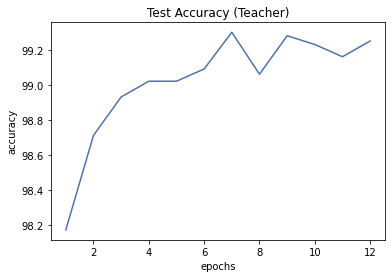

In [ ]:
# Plot the accuracy_T vs. epochs curve
color_list = sns.color_palette('deep')
plt.plot(range(1,NUM_EPOCHS+1),accuracy_T,color = color_list[0])
plt.title('Test Accuracy (Teacher)')
plt.xlabel('epochs')
plt.ylabel('accuracy')


# Save the f1 score vs. epochs curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('f1_score.jpg')
os.chdir('/content/drive/MyDrive/Task2/Results')
T_dict={'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_T':accuracy_T}
savemat('accuracy_T.mat',T_dict)


In [ ]:
# Train the student model
base_student = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
simgs = base_student.input
smidput = base_student(simgs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
smidput = keras.layers.GlobalAveragePooling2D()(smidput)
# A Dense classifier with a single unit (binary classification)
soutputs = Dense(2)(smidput)
student_model = keras.Model(simgs, soutputs)
ALPHA = 0.2
DISTILLATION_TEMPERATURE = 64
fc_model=build_fc_model()
accuracy_S_KD = train_and_evaluate(fc_model,compute_student_loss)

Epoch 1: Class_accuracy: 96.89%
Epoch 2: Class_accuracy: 98.00%
Epoch 3: Class_accuracy: 98.40%
Epoch 4: Class_accuracy: 98.54%
Epoch 5: Class_accuracy: 98.59%
Epoch 6: Class_accuracy: 98.68%
Epoch 7: Class_accuracy: 98.78%
Epoch 8: Class_accuracy: 98.79%
Epoch 9: Class_accuracy: 98.84%
Epoch 10: Class_accuracy: 98.90%
Epoch 11: Class_accuracy: 98.87%
Epoch 12: Class_accuracy: 98.87%


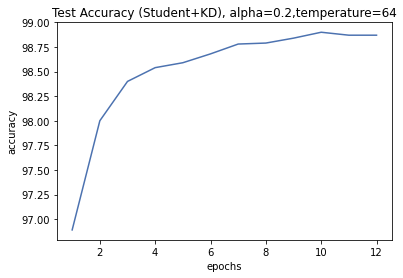

In [ ]:
# Plot the accuracy_S_KD vs. epochs curve
plt.plot(range(1,NUM_EPOCHS+1),accuracy_S_KD,color = color_list[0])
plt.title('Test Accuracy (Student+KD), alpha=0.2,temperature=64')
plt.xlabel('epochs')
plt.ylabel('accuracy')


# Save the accuracy_S_KD vs. epochs curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_KD.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_dict={'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_S_KD':accuracy_S_KD}
savemat('accuracy_S_KD.mat',S_KD_dict)


# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ACC = []
ALPHA = 0.5
temperatures = [1,2,4,16,32,64]
for temperature in temperatures:
  DISTILLATION_TEMPERATURE = temperature
  fc_model=build_fc_model()
  accuracy = train_and_evaluate(fc_model,compute_student_loss)
  ACC.append(accuracy[-1])
  print(ACC)
accuracy_S_KD = ACC

Epoch 1: Class_accuracy: 96.84%
Epoch 2: Class_accuracy: 97.70%
Epoch 3: Class_accuracy: 97.83%
Epoch 4: Class_accuracy: 97.87%
Epoch 5: Class_accuracy: 97.74%
Epoch 6: Class_accuracy: 98.20%
Epoch 7: Class_accuracy: 98.18%
Epoch 8: Class_accuracy: 98.17%
Epoch 9: Class_accuracy: 98.35%
Epoch 10: Class_accuracy: 98.31%
Epoch 11: Class_accuracy: 98.11%
Epoch 12: Class_accuracy: 98.09%
[<tf.Tensor: shape=(), dtype=float32, numpy=98.09>]
Epoch 1: Class_accuracy: 96.56%
Epoch 2: Class_accuracy: 97.57%
Epoch 3: Class_accuracy: 97.82%
Epoch 4: Class_accuracy: 98.30%
Epoch 5: Class_accuracy: 98.30%
Epoch 6: Class_accuracy: 98.29%
Epoch 7: Class_accuracy: 98.28%
Epoch 8: Class_accuracy: 98.43%
Epoch 9: Class_accuracy: 98.36%
Epoch 10: Class_accuracy: 98.48%
Epoch 11: Class_accuracy: 98.47%
Epoch 12: Class_accuracy: 98.48%
[<tf.Tensor: shape=(), dtype=float32, numpy=98.09>, <tf.Tensor: shape=(), dtype=float32, numpy=98.479996>]
Epoch 1: Class_accuracy: 96.71%
Epoch 2: Class_accuracy: 97.83%
Epo

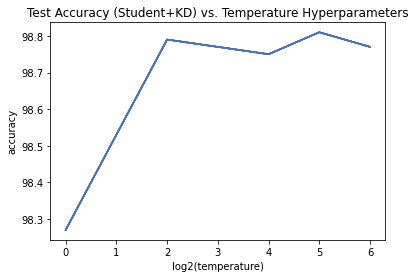

In [ ]:
# Plot the accuracy_S vs. temperatures curve
log2_temperatures = [math.log2(x) for x in temperatures]
for i, temperature in enumerate(temperatures):
  plt.plot(log2_temperatures,accuracy_S_KD,color = color_list[0])
plt.title('Test Accuracy (Student+KD) vs. Temperature Hyperparameters')
plt.xlabel('log2(temperature)')
plt.ylabel('accuracy')


# Save the accuracy_S curve vs. temperatures curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_KD__vs_Temp.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_dict={'temperatures':temperatures, 'accuracy_S_KD':accuracy_S_KD}
savemat('accuracy_S_KD_vs_Temp.mat',S_KD_dict)

# Test accuracy vs. alpha and tempreture curve

In [ ]:
ACC = []
temperatures = [1,2,4,16,32,64,128]
alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for alpha in alphas:
  for temperature in temperatures:
    ALPHA = alpha
    DISTILLATION_TEMPERATURE = temperature
    fc_model=build_fc_model()
    accuracy = train_and_evaluate(fc_model,compute_student_loss)
    ACC.append(accuracy[-1])
    print(ACC)
accuracy_S_KD_T_alpha = ACC

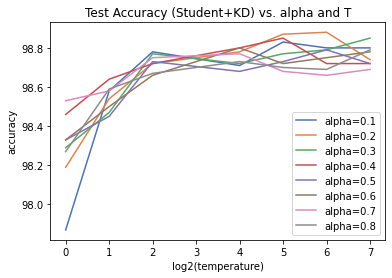

In [ ]:
# Plot the accuracy_S vs. alphas and temperatures curve
log2_temperatures = [math.log2(x) for x in temperatures]
for i, alpha in enumerate(alphas):
  plt.plot(log2_temperatures,accuracy_S_KD_T_alpha[i*7:(i+1)*7],color=color_list[i],label="alpha="+str(alpha))
  plt.legend()
plt.title('Test Accuracy (Student+KD) vs. alpha and T')
plt.xlabel('log2(temperature)')
plt.ylabel('accuracy')

# Save the accuracy_S curve vs. alphas and temperatures curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_KD__vs_Temp_alpha.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_T_alpha_dict={'temperatures':temperatures,'alphas':alphas,'accuracy_S_KD_T_alpha':accuracy_S_KD_T_alpha}
savemat('accuracy_S_KD_vs_Temp_alpha.mat',S_KD_T_alpha_dict)

# Train student from scratch

In [ ]:
# Build fully connected student.
base_student_scratch = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
simgs = base_student_scratch.input
smidput = base_student_scratch(simgs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
smidput = keras.layers.GlobalAveragePooling2D()(smidput)
# A Dense classifier with a single unit (binary classification)
soutputs = Dense(2)(smidput)
student_model_scratch = keras.Model(simgs, soutputs)


#test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = student_model_scratch(images, training=True)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,tf.nn.softmax(student_subclass_logits))
  
  return cross_entropy_loss

base_student_scratch.trainable = False
inif1_scratch = train_and_evaluate(student_model_scratch,compute_plain_cross_entropy_loss,10,1e-3)
#Fine-tuning
base_student_scratch.trainable = True
finf1_scratch = train_and_evaluate(student_model_scratch,compute_plain_cross_entropy_loss,25,1e-4)

1/1 [==============================] - 0s 31ms/step
0.7725919629186289
1/1 [==============================] - 0s 28ms/step
0.7725919629186289
1/1 [==============================] - 0s 32ms/step
0.7725919629186289
1/1 [==============================] - 0s 34ms/step
0.7725919629186289
1/1 [==============================] - 0s 30ms/step
0.7725919629186289
1/1 [==============================] - 0s 40ms/step
0.7725919629186289
1/1 [==============================] - 0s 38ms/step
0.7725919629186289
Epoch 8: 

KeyboardInterrupt: ignored

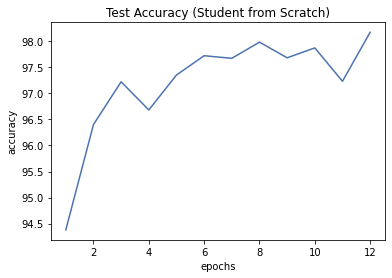

In [ ]:
# Plot the accuracy_S vs. epochs curve
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.plot(range(1,NUM_EPOCHS+1),accuracy_S,color=color_list[0])
plt.title('Test Accuracy (Student from Scratch)')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# Save the accuracy_S vs. epochs curve and data
plt.savefig('Test_Accuracy_S.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_dict = {'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_S':accuracy_S}
savemat('accuracy_S.mat',S_dict)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

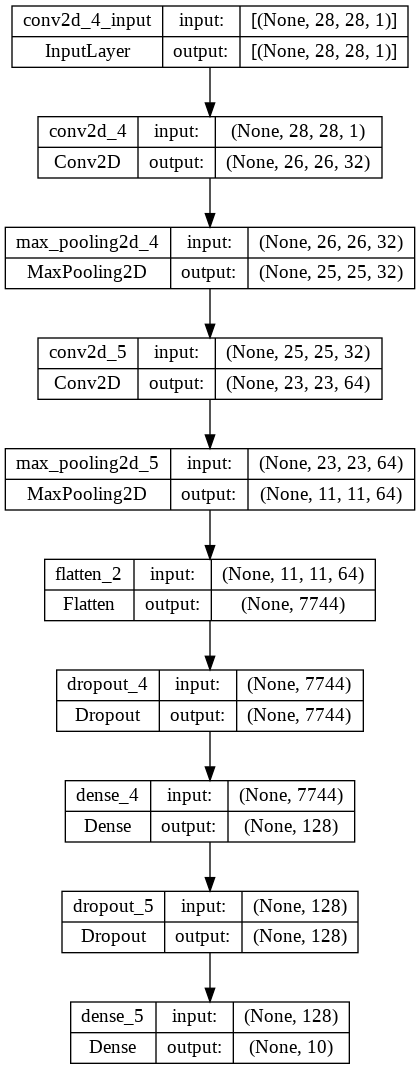

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 23, 23, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                    

In [ ]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 activation_3 (Activation)   (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 activation_4 (Activation)   (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
No

In [ ]:
fc_model_no_distillation.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 784)               615440    
                                                                 
 activation_9 (Activation)   (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 784)               615440    
                                                                 
 activation_10 (Activation)  (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
No

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12


# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
